In [63]:
%matplotlib inline

from PIL import Image
from PIL import ImageFilter
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
import math
import tabulate

def plot_two_image(first_image, first_description, second_image, second_description):
    fig = plt.figure()
    
    a = fig.add_subplot(1, 2, 1)
    imgplot = plt.imshow(first_image)
    a.set_title(first_description)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(second_image)
    a.set_title(second_description)

    
def binarize_image(image, threshold):
    image = image.convert('LA')
    image = np.array(image)
    for raw in image:
        for column in raw:
            column[0] = 255 if column[0] < threshold else 0
    return Image.fromarray(image)


def get_centroids(image):
    label_img = label(image)
    regions = regionprops(label_img)
    return np.array([region.centroid for region in regions])


def points_to_image(image, points):
    array = np.array(image)
    for y, x in points:
        array[int(y), int(x)] = [0, 255]

    image = Image.fromarray(array)
    return image


In [6]:

# set current_directory with Path function cwd() [Current Working Directory]
current_directory = Path.cwd()

# path to access our image
image_path = current_directory.joinpath('img/unprepared_image.png')

print(f'Current directory: {current_directory}')
print(f'Image path: {image_path}')

# open image with Pillow
raw_image = Image.open(image_path)
# convert image to grayscale
image_grayscale = raw_image.convert(mode='LA')

Current directory: /Users/mor1ins/projects/diploma
Image path: /Users/mor1ins/projects/diploma/img/unprepared_image.png


# Декодирование позиции

## Обработка изображения


В умных ручках используются инфракрасные камеры и прозрачные в этом спектре
чернила. За счет этого чернила не мешают позиционироваться на листах при письме.
Камера же делает снимки только тогда, когда на стержень оказывается давление.
Поэтому задача оцифровки рукописного текста и изображений в случае умных ручек
сводится к правильному декодированию последовательности таких снимков в координаты.


Первым этапом декодирования, после получения изображения, содержащего блок
минимального размера (8x8), является препроцессинг. **Исходное изображение (а)** 
переводится в **оттенки серого (б)**, а потом **бинаризуется (в)** (значение порога выведено 
эмпирически). Из получившегося изображения необходимо **удалить шумы (г)**, чтобы убрать 
артефакты печати и повысить качество распознавания. Для этого используется медианный 
фильтр (значение которого также выведено эмпирически).

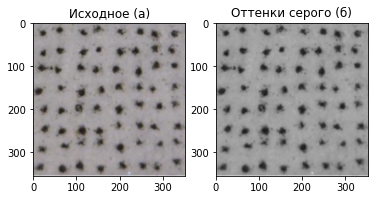

In [114]:
plot_two_image(raw_image, 'Исходное (а)', image_grayscale, 'Оттенки серого (б)')

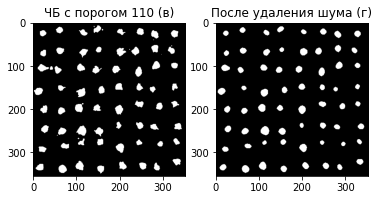

In [116]:
threshold_for_bw = 110
black_white_image = binarize_image(image_grayscale, threshold=threshold_for_bw)
deleted_noise_image = black_white_image.filter(ImageFilter.MedianFilter(11))

plot_two_image(
    black_white_image, f'ЧБ с порогом {threshold_for_bw} (в)', 
    deleted_noise_image, 'После удаления шума (г)')

Нужно отметить, что в данном изложении алгоритма используются относительно выровненные изрбражения.
Ручка же делает снимки под наклоном в силу того, что это происходит при письме. Причем важно учесть,
что угол наклона может варьироваться очень сильно, что делает позиционирование невозможным без
выравнивания изображения.

Точки исходного изображения представляются на бинаризованном изображении в виде областей белых пикселей.
С помощью инструмента regionprops из пакета skimage находим центроиды данных областей (изображений (а) показывает бинарное изображение с наложенными центроидами, а изображение (б) только центроиды). 

Важно отметить, что в случае неправильной фильтрации изображения, слишком низком пороге для бинаризации, некачественного исходного снимка, либо поврежденного бумажного носителя может возникнуть ситуация, когда возникнут лишние точки, либо пропадут нужные. В случае первых двух проблем нужно провести эксперименты для вычисления оптимальных параметров, а в случае других - попробовать поискать на изображении другой валидный блок, если таких нет, а коррекция ошибок не справляется - спозиционироваться невозможно.

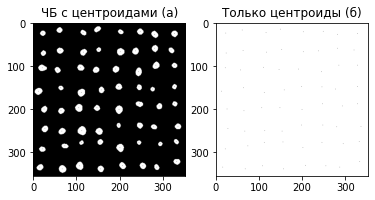

In [119]:
pixels_array = np.array(deleted_noise_image.convert(mode='1'))
centroids = get_centroids(pixels_array) 

plot_two_image(points_to_image(deleted_noise_image, centroids), 'ЧБ с центроидами (а)',
               points_to_image(np.zeros_like(deleted_noise_image), centroids), 'Только центроиды (б)')

In [82]:
def print_columns(it):
    print(tabulate.tabulate(it, [f'Col {i}' for i in range(1, N + 1)], tablefmt="fancy_grid"))

centroids_in_grid = centroids[np.argsort(centroids[:, 0])].reshape(N, N, 2)

for i in range(N):
    centroids_in_grid[i] = centroids_in_grid[i][np.argsort(centroids_in_grid[i][:, 1])]
    
N = int(math.sqrt(len(centroids)))

x_coordinates_of_centroids = centroids_in_grid[:, :, 0]
print_columns(x_coordinates_of_centroids.transpose())

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│   Col 1 │   Col 2 │   Col 3 │   Col 4 │   Col 5 │   Col 6 │   Col 7 │   Col 8 │
╞═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│ 22.3136 │ 60.797  │ 115.976 │ 148.362 │ 201.971 │ 247.07  │ 280.584 │ 326.136 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 23.5877 │ 62.1212 │ 116.097 │ 151.284 │ 201.775 │ 236.168 │ 280.983 │ 318.938 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 21.1843 │ 56.3451 │ 109.746 │ 145.16  │ 190.906 │ 243.4   │ 283.59  │ 326.134 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 12.3972 │ 63.9681 │ 111.246 │ 157.633 │ 197.647 │ 244.785 │ 275.593 │ 326.051 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│ 25.5926 │ 64.9097 │ 105.657 │ 147.294 │ 198.2   │ 245.096 │ 291.181 │ 326.887 │
├─────────┼─────

In [83]:
def print_rows(it):
    print(tabulate.tabulate(
        [[f'Row {i}'] + list(row) for i, row in zip(range(1, N + 1), it)], 
        [], tablefmt="fancy_grid"))

y_coordinates_of_centroids = centroids_in_grid[:, :, 1]
print_rows(y_coordinates_of_centroids.transpose())

╒═══════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│ Row 1 │  25.3475 │  18.1429 │  24.0635 │  16.0921 │  22.1524 │  21.6772 │  28.0216 │  26.6331 │
├───────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Row 2 │  71.3246 │  65.5636 │  69.233  │  63.3068 │  68.1982 │  66.7011 │  60.5491 │  64.8281 │
├───────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Row 3 │ 105.429  │ 110.092  │ 104.74   │ 109.809  │ 108.486  │ 114.423  │  99.65   │  99.6807 │
├───────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Row 4 │ 159.215  │ 151.511  │ 162.279  │ 156.17   │ 148.76   │ 149.992  │ 154.358  │ 148.602  │
├───────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ Row 5 │ 200.747  │ 204.284  │ 197.556  │ 197.797  │ 201.488  │ 188.687  │ 193.771  │ 188.198  │
├───────┼──────────┼

In [105]:
max_x = x_coordinates_of_centroids.max(axis = 1)
min_x = x_coordinates_of_centroids.min(axis = 1)
difference_x = max_x - min_x

# intervals_x = [[1/3 * difference_x.max(), 2/3 * difference_x.max(), difference_x.max()]]
average_x = x_coordinates_of_centroids.mean(axis = 1)

threshold_for_class = 2/3 * difference_x.max()
classes_x = [ 'A' if diff > threshold_for_class else 'B' for diff in difference_x ]
print()
print(tabulate.tabulate(
        [['min'] + list(min_x), ['max'] + list(max_x), 
         ['diff'] + list(difference_x), ['avg'] + list(average_x)
        ], [f'x_{i}' for i in range(N)], tablefmt="fancy_grid"
    )
)

print(tabulate.tabulate(
    [['class'] + classes_x], [f'x_{i}' for i in range(N)], tablefmt="fancy_grid"
))
# print(tabulate.tabulate(intervals_x, ['1/3 max', '2/3 max', 'max'], tablefmt="fancy_grid"))


╒══════╤═════════╤═════════╤══════════╤══════════╤══════════╤══════════╤══════════╤══════════╕
│      │     x_0 │     x_1 │      x_2 │      x_3 │      x_4 │      x_5 │      x_6 │      x_7 │
╞══════╪═════════╪═════════╪══════════╪══════════╪══════════╪══════════╪══════════╪══════════╡
│ min  │ 12.3972 │ 56.3451 │ 105.657  │ 145.16   │ 190.906  │ 236.168  │ 275.593  │ 318.938  │
├──────┼─────────┼─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ max  │ 27.1503 │ 73.2761 │ 116.097  │ 157.633  │ 206.244  │ 253.091  │ 293.308  │ 334.199  │
├──────┼─────────┼─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ diff │ 14.7531 │ 16.931  │  10.4397 │  12.4722 │  15.3384 │  16.9224 │  17.7151 │  15.2612 │
├──────┼─────────┼─────────┼──────────┼──────────┼──────────┼──────────┼──────────┼──────────┤
│ avg  │ 21.1529 │ 64.4665 │ 111.302  │ 151.597  │ 199.364  │ 245.019  │ 283.636  │ 327.543  │
╘══════╧═════════╧═════════╧══════════╧══════════

In [108]:
max_y = y_coordinates_of_centroids.max(axis = 0)
min_y = y_coordinates_of_centroids.min(axis = 0)
difference_y = max_y - min_y


threshold_for_class = 2/3 * difference_y.max()
classes_y = [ 'A' if diff > threshold_for_class else 'B' for diff in difference_y ]
average_y = y_coordinates_of_centroids.mean(axis = 0)

print(tabulate.tabulate(
    zip([f'y_{i}' for i in range(N)], min_y, max_y, difference_y, average_y, classes_y), 
    ['min', 'max', 'diff', 'avg', 'class'], tablefmt="fancy_grid")
)

# print(tabulate.tabulate(intervals_y, ['1/3 max', '2/3 max', 'max'], tablefmt="fancy_grid"))

╒═════╤══════════╤══════════╤═════════╤══════════╤═════════╕
│     │      min │      max │    diff │      avg │ class   │
╞═════╪══════════╪══════════╪═════════╪══════════╪═════════╡
│ y_0 │  16.0921 │  28.0216 │ 11.9295 │  22.7663 │ A       │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────┤
│ y_1 │  60.5491 │  71.3246 │ 10.7754 │  66.2131 │ B       │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────┤
│ y_2 │  99.65   │ 114.423  │ 14.7727 │ 106.539  │ A       │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────┤
│ y_3 │ 148.602  │ 162.279  │ 13.6771 │ 153.861  │ A       │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────┤
│ y_4 │ 188.198  │ 204.284  │ 16.0858 │ 196.566  │ A       │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────┤
│ y_5 │ 237.798  │ 251.578  │ 13.7803 │ 244.551  │ A       │
├─────┼──────────┼──────────┼─────────┼──────────┼─────────┤
│ y_6 │ 275.32   │ 292.696  │ 17.3757 │ 281.83   │ A       │
├─────┼──────────┼──────

In [111]:
def split_into_three_intervals(minimum, maximum):
    diff = maximum - minimum
    border_1 = minimum + 1/3 * diff
    border_2 = minimum + 2/3 * diff
    return ((minimum, border_1), (border_1, border_2), (border_2, maximum))


def value_belongs_to_interval(value, interval):
    return interval[0] <= value and value <= interval[1]


def get_position_code(value, value_class, intervals, codes):
    if value_class == 'A':
        for i in range(len(intervals)):
            if value_belongs_to_interval(value, intervals[i]):
                return codes[i]
    else:
        if value_belongs_to_interval(value, intervals[1]):
            return -2
        elif value_belongs_to_interval(value, intervals[2]):
            return 2
        else:
            

        
intervals_x = [split_into_three_intervals(*minmax) for minmax in zip(min_x, max_x)]
posibles_codes = [-1, 0, 1]


x_codes = np.zeros_like(x_coordinates_of_centroids)
for i in range(len(x_coordinates_of_centroids)):
    for j in range(len(x_coordinates_of_centroids[i])):
        value = x_coordinates_of_centroids[i,j]
        interval = intervals_x[i]
        x_codes[i,j] = get_position_code(value, classes_x[i], interval, posibles_codes)

print_columns(x_codes)

╒═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════╕
│   Col 1 │   Col 2 │   Col 3 │   Col 4 │   Col 5 │   Col 6 │   Col 7 │   Col 8 │
╞═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════╡
│       1 │       1 │       0 │      -1 │       1 │       1 │       0 │      -1 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│      -1 │       0 │      -1 │       0 │       0 │       0 │       1 │       1 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│       2 │       2 │      -2 │      -2 │     nan │       2 │      -2 │     nan │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│      -1 │       0 │      -1 │       1 │      -1 │       0 │       1 │       1 │
├─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┤
│       1 │       1 │      -1 │       0 │       0 │       0 │       0 │       1 │
├─────────┼─────

In [90]:
intervals_y = [split_into_three_intervals(*minmax) for minmax in zip(min_y, max_y)]

y_codes = np.zeros_like(y_coordinates_of_centroids)
for i in range(len(y_coordinates_of_centroids)):
    for j in range(len(y_coordinates_of_centroids[i])):
        value = y_coordinates_of_centroids[j,i]
        interval = intervals_y[i]
        y_codes[j,i] = get_position_code(value, interval, posibles_codes)

print_rows(y_codes)

╒═══════╤════╤════╤════╤════╤════╤════╤════╤════╕
│ Row 1 │  1 │  1 │  0 │  1 │  1 │  0 │  1 │  1 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 2 │ -1 │  0 │  1 │ -1 │  1 │  1 │  0 │  1 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 3 │  1 │  1 │  0 │  1 │  0 │  1 │ -1 │  0 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 4 │ -1 │ -1 │  1 │  0 │  0 │  1 │ -1 │  1 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 5 │  0 │  1 │  0 │ -1 │  1 │ -1 │  1 │  0 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 6 │  0 │  0 │  1 │ -1 │ -1 │ -1 │ -1 │  0 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 7 │  1 │ -1 │ -1 │  0 │  0 │ -1 │ -1 │  1 │
├───────┼────┼────┼────┼────┼────┼────┼────┼────┤
│ Row 8 │  1 │  0 │ -1 │ -1 │ -1 │ -1 │ -1 │ -1 │
╘═══════╧════╧════╧════╧════╧════╧════╧════╧════╛
